# Practical 1: Dimensionality Reduction

**Course:** WBCS032-05 Introduction to Machine Learning  
**Student Names:**

Avery Kozák (s5559294) & Rik de Hoop (s5303893)

---

## Assignment Overview

In this assignment, you will implement Principal Component Analysis (PCA) to reduce the dimensionality of the data, as discussed in the lecture.

You will work with the `COIL20.mat` dataset on Themis. The dataset consists of 1440 images, where each image has a size of $32 \times 32$ pixels and is flattened into a vector of length 1024. All images are stored in one matrix of size $1440 \times 1024$, where each row represents one image and each column corresponds to a pixel. The images come from 20 different objects, and each object is recorded at 72 different rotation angles, with a rotation step of 5 degrees.

## 1. Introduction (1 point)

Describe the goal of this assignment and briefly explain why dimensionality reduction and PCA are useful in data analysis.

**Your answer here:**

Analyzing data with a high number of variables is computationably expensive. With dimensionality reduction redundant variables and noise are removed so that analysis gets easier.

## 2. Methods (3 points)

### 2.1 Explain the PCA Algorithm (0.5 points)

Explain the PCA algorithm in a general manner.

**Your answer here:**

- Standardize data, to mean zero
- Compute covariance matrix
- Calculate eigenvectors (principal components)
- Sort them by their values


### 2.2 Implementation (2.5 points)

You need to implement the PCA algorithm **yourself**. Both the code quality and correctness will be graded.

*__Note:__* **Do not change the cell labels! Themis will use them to automatically grade your submission.**

In [ ]:
# Load required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.manifold import TSNE

# Data configuration
data_file_path = 'COIL20.mat'
image_shape = (32, 32)

# PCA parameters
d = 40  # Target dimensionality

# t-SNE parameters
tsne_perplexity = 4

#### PCA Algorithm Steps

Implement the following steps:

1. **Normalize the data:**
   $$Z = \frac{X - \mu}{\sigma}$$
   where $\mu$ is the mean of all samples and $\sigma$ is the standard deviation.

2. **Compute the covariance matrix of the normalized data** and obtain its eigenvalues $D$ and eigenvectors $U$.  
   You may use `np.linalg.eig` in Python.

3. **Sort the eigenvectors in descending order of their eigenvalues** and select the first $d$ principal components to form $U_d$.

4. **Reduce the dimensionality of the data** by projecting the normalized data onto the selected principal components.

In [ ]:
# Implement PCA here
def PCA(x, d):
    """
    Apply Principal Component Analysis.

    Args:
        x (np.ndarray): Dataset matrix (each column represents a variable)
        d (int): Dimensionality of the projection

    Returns:
        tuple: (U_d, eigen_values, Z_d)
            - U_d (np.ndarray): Matrix of principal components, sorted descending
            - eigen_values (np.ndarray): Eigenvalues, sorted descending
            - Z_d (np.ndarray): Reduced version of the dataset
    """
    
    # 1. normalize the data
    mean = np.mean(x, axis=0)
    sd = np.std(x, axis=0)
    norm_x = (x-mean) / sd

    # 2. calculate cov. matrix, obtain its D, U (=> cv_eval, cv_evec)
    covmat = np.cov(norm_x, rowvar=False)
    (cv_eval, cv_evec) = np.linalg.eig(covmat)

    # 3. sort these in descending order
    # (linalg.eig returns eigenvectors in wrong orientation! transposing fixes this.)
    eigen = sorted(list(zip(cv_eval, cv_evec.transpose())), key=lambda tup:tup[0], reverse=True)
    (eigvals, eigvecs) = zip(*eigen)
    
    # 4. select first d columns of eigenvector matrix.
    # turn this into a matrix, apply to our normalised values => reduced dataset
    first_d_principals = np.array(eigvecs[0:d])
    umat = np.array(first_d_principals)
    reduced = np.matvec(umat, norm_x)

    # return *all* principal components and eigenvalues, but *only* the reduced (transformed) dataset (given param. d)
    # (output expects this matrix transposed)
    return (umat.transpose(), np.array(eigvals), reduced)

In [ ]:
# Extract dataset
# (Images are stored in matrix under "X")
dataset = scipy.io.loadmat(data_file_path)["X"]

In [ ]:
# Apply PCA to the dataset
U_d, eigen_values, Z_d = PCA(dataset, d)

## 3. Experimental Results (4 points)

*__Note:__* This section is not graded by Themis.

### 3.1 Eigenvalue Profile

Write code in the cell below to plot the eigenvalue profile of the data. This plot helps determine how many principal components to retain for dimensionality reduction. Make sure that all plots are clearly labeled. Each figure must include labeled axes, an appropriate title, and a legend where applicable.

- **X-axis:** Eigenvalue indices $(1, 2, \ldots, 1024)$
- **Y-axis:** Eigenvalue magnitude

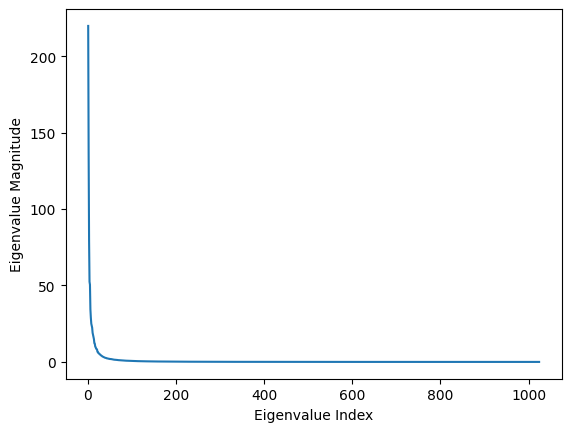

In [ ]:
# Eigenvalue indices
indices = np.arange(1, len(eigen_values) + 1)
plt.plot(indices, eigen_values)

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue Magnitude")

plt.show()

### 3.2 Dimensionality Table

Create a table reporting the dimensionality $d$ required to keep 0.9, 0.95, and 0.98 fraction of the total variance. Write code in the cell below to compute these values, then fill in the table.

Use the formula:
$$d = \frac{\sum_{i=1}^{d}\lambda_i}{\sum_{i=1}^{n}\lambda_i}$$

In [ ]:
eigen_values = np.array(eigen_values)
total_variance = np.sum(eigen_values)

# Cumulative explained variance ratio
cum_var_ratio = np.cumsum(eigen_values) / total_variance

# index trick, converts array to boolean array, then uses numpy argmax to find the first where the condition is true
d_90 = np.argmax(cum_var_ratio >= 0.90) + 1
d_95 = np.argmax(cum_var_ratio >= 0.95) + 1
d_98 = np.argmax(cum_var_ratio >= 0.98) + 1

print(f"d_90={d_90}, d_95={d_95}, d_98={d_98}")


d_90=55, d_95=107, d_98=206


| Variance Fraction | Dimensionality (d) |
|-------------------|-------------------|
| 0.90              | 55                |
| 0.95              | 107               |
| 0.98              | 206               |

### 3.3 t-SNE Visualization

Visualize the reduced data using t-SNE in a 2-dimensional feature space.

- Use different colors for data points from different objects
- Every 72 data examples correspond to one object
- You can use `sklearn.manifold.TSNE` in Python with the configured perplexity parameter

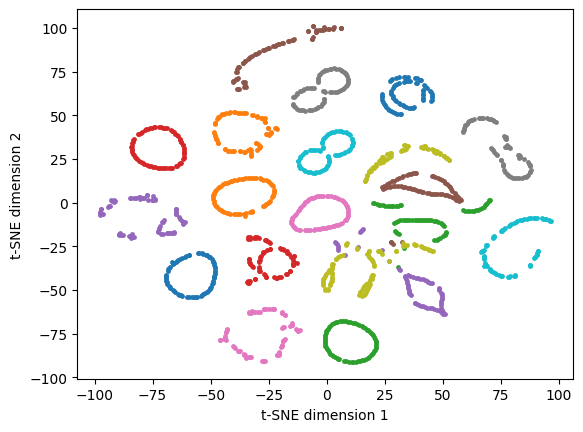

In [ ]:
num_objects = 20
samples_per_object = 72

labels = np.repeat(np.arange(num_objects), samples_per_object)

Z_tsne = TSNE(n_components=2, perplexity=tsne_perplexity).fit_transform(Z_d)

for obj in range(num_objects):
    idx = labels == obj
    plt.scatter(Z_tsne[idx, 0], Z_tsne[idx, 1], label=f"Object {obj + 1}", s=6)

plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")

plt.show()


## 4. Discussion (2 points)

Discuss your observations on the obtained results:
- What does the eigenvalue profile tell you about the data?
- How well does PCA reduce the dimensionality while preserving variance?
- What do you observe in the t-SNE visualization? Are the objects well-separated?

**Your answer here:**

- The eigenvalue associated with a variable shows how much information is preserved when using the variable. In the case of this data, the values sharply drop after about 50 dimensions, making the variables less relevant.
- the PCA algorithm reduces a relatively high amount of redundant dimensions relative to how much variance is retained. For example from 1024 to 206 dimensions preserves 98% of variance.
- the objects are clearly distinct, points belonging to the same object are close together, and from different objects are separate

### A note on Themis
Themis will only grade your implementation of the PCA algorithm, thus giving a maxiumum of `2.5` points. It does so by executing every cell up to and including the PCA call. Make sure your code runs without errors and produces the expected outputs before submitting.

## Contribution

State your individual contribution.

**Your answer here:**

Rik: 3 and part of 4

Avery: 1, 2, and part of 4